<b>Summary:</b> Using cifar dataset from torchvission of pytorch to create CNN classifier from scratch

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

#### Download the CIFAR dataset from the Pytorch library
The torchvision module contains a number of datasets which are meant to help Pytorch users practice building models with them. We use one of these datasets here. The datasets are available in torchvision.datasets.

By specifying <b>train = True</b> we will load the training data from the dataset

In [17]:
trainset = torchvision.datasets.CIFAR10(root='./datasets',
                                        train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

Files already downloaded and verified


In [18]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Data Loaders
Data loader combines a dataset and provides single or multi-process iterators over the dataset
* <b>batch_size</b> = how many samples per batch to load (default: 1).<br>
* <b>shuffle = True</b>, to have the data reshuffled at every epoch <br>
* <b>num_workers= 2</b>, 2 subprocesses will be used for data loading.
0 means that the data will be loaded in the main process. (default: 0)

In [19]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=2)

#### Load the CIFAR test dataset
We specify <b>train=False</b> in this case

In [20]:
testset = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=False,
                                       download=True,
                                       transform=transforms.ToTensor())

Files already downloaded and verified


In [21]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

#### Use a DataLoader to prepare our test data

In [22]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=8,
                                         shuffle=False,
                                         num_workers=2)

#### Create a tuple containing the unique labels in our dataset

In [23]:
labels = ('plane', 'car', 'bird', 'cat','deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

## Examining the datasets
We will view some of the images in the datasets for which we first need to import Matplotlib and Numpy

In [24]:
import matplotlib.pyplot as plt
import numpy as np

#### Get a batch from the training data
The DataLoader object divides the dataset into batches. Here we examine the first batch of the training data set

In [25]:
images_batch, labels_batch = iter(trainloader).next()

#### Check out the shape of this batch of images
The first dimension gives the number of images. The next dimension represents the number of channels. The last two give the image size

In [26]:
images_batch.shape

torch.Size([8, 3, 32, 32])

#### Create a grid to display the batch of images
torchvision is a module which contains datasets, model architectures and image transformation tools. Here, we use one of its utilities to create a grid of images from our batch 

In [27]:
img = torchvision.utils.make_grid(images_batch)

#### Examine the shape
The grid effectively contains all the 8 images placed side by side with padding of 2 pixels between the images and at the edges of the grid

In [28]:
img.shape

torch.Size([3, 36, 274])

#### Transposing the image
We will use np.transpose to change the shape of image tensor<br>
<b>.imshow()</b> needs a 2D array, or a 3D array with the third dimension being of size 3 or 4 only (For RGB or RGBA), so we will shift first axis to last<br>
Ref - https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow

In [29]:
np.transpose(img, (1,2,0)).shape

torch.Size([36, 274, 3])

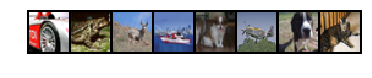

In [30]:
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off')
plt.show()

In [31]:
import torch.nn as nn

#### Configuring the neural network
* The input size will be the 3 channels of the images
* The first convolution will produce 16 channels
* The second convolution produces 32 channels
* The final output will have a size equal to the number of classes for the prediction
* The convolving kernel will have a size of 5

In [32]:
in_size = 3
hid1_size = 16
hid2_size = 32
out_size = len(labels)
k_conv_size = 5 

### Define the Convolutional Neural Network

<b>Conv2d: </b>Applies a 2D convolution over an input signal composed of several input planes.<br>
Parameters<br>
in_channels (int) – Number of channels in the input image<br>
out_channels (int) – Number of channels produced by the convolution<br>
kernel_size (int or tuple) – Size of the convolving kernel<br>

<b>BatchNorm2d: </b>Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .
Parameters<br>
num_features – C from an expected input of size (N,C,H,W)

<b>ReLU: </b>Activation function

<b>Maxpool2d: </b>
Parameters:<br>
kernel_size – the size of the window to take a max over

<b>Linear: </b>
Parameter:<br>

in_features: 
All the operations above used 4D Tensors of shape => torch.Size([8, 32, 5, 5]), where 8 are number of images per batch<br>
Now for fully connected layers(linear layers) we need to transform them in 1D Tensors<br>
So to the in_features of fully connected layer we will give **32\*5\*5** (hid2_size X k_conv_size X k_conv_size)

out_features:<br>
num_classes = since we are using Cifar10 we have 10 labels  

In [33]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size ),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(hid2_size *  k_conv_size * k_conv_size, out_size)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [34]:
model = ConvNet()

#### Define the Learning Rate, Loss Function and Optimizer

In [35]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

#### Training the model

<b>Forward Pass: </b> 
Predict Output from train data and then compute loss using CrossEntropyLoss() defined above

<b>Backward Pass: </b>
Firstly zero all the gradient variables and then back propogate<br>
We are using Adam optimizer to optimize our model at every step


In [36]:
total_step = len(trainloader)
num_epochs = 5


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [2000/6250], Loss: 1.1283
Epoch [1/5], Step [4000/6250], Loss: 0.8529
Epoch [1/5], Step [6000/6250], Loss: 1.2899
Epoch [2/5], Step [2000/6250], Loss: 0.3461
Epoch [2/5], Step [4000/6250], Loss: 1.3728
Epoch [2/5], Step [6000/6250], Loss: 1.1091
Epoch [3/5], Step [2000/6250], Loss: 0.7644
Epoch [3/5], Step [4000/6250], Loss: 1.5761
Epoch [3/5], Step [6000/6250], Loss: 0.6908
Epoch [4/5], Step [2000/6250], Loss: 0.5618
Epoch [4/5], Step [4000/6250], Loss: 0.7671
Epoch [4/5], Step [6000/6250], Loss: 1.1010
Epoch [5/5], Step [2000/6250], Loss: 0.8889
Epoch [5/5], Step [4000/6250], Loss: 1.1156
Epoch [5/5], Step [6000/6250], Loss: 1.1683


#### Evaluate the model
model.eval() sets our model in evaluation(test) mode <br>
We will use test data to check accuracy of our model

In [37]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the 10000 test images: {}%'\
          .format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 70.05 %
